### Fracture dissolution model





### Simulation specifications:

$ q_0 = 10^{-7} \space m^2/s $ 

$ h_0 = 2*10^{-4} \space m $ 

$ u_0 = q_0/h_0 = 5*10^{-4} m/s $

$ L = 20 \space m $ 

$ k = 2.5 * 10^{-7} \space m/s $

$ Pe = q_0 / D = 100 $

$ Da = kh_0/q_0 = 0.05 $

Penetration length:

$$ l_p = q / 2 k = 0.2 \space m $$

Time scale (time it takes for initial fracture to double):

$$ \tau = \frac{h_0c_{sol}}{2kc_{sat}} = 5.4 * 10^6 \space s $$




For 1D (pseudo 1D):

$$ h(x,t) = h_0(1 + \frac{te^{-x/l_p}}{\tau}) $$


# Lattice units:

$ C_l = 0.001 \space m $

$ C_{\nu} = 6 * 10^{-5} \space m^2/s $

$ u^* = \frac{Q}{C_U} = \frac{UC_l}{C_{\nu}} $

$ \nu = \nu^* C_{\nu} = \text{const}$

$ Q = u^*C_U = \text{const} $

$ C_l \nearrow \implies u^* \nearrow $

$ N \nearrow \implies u^* \searrow $

$ C_{\nu} \nearrow \implies u^* \searrow $

$ \nu^* \nearrow \implies u^* \nearrow $

$ \tau^* = 3\nu^* + 0.5 $

$ Re = \frac{l^* Q^*}{c_s^{*2}(\tau^*-0.5)}$

$ \Delta t = \frac{\Delta x}{C_u} $

$ C_u \propto 1/Ma^{(l)}$

$ \Delta t \propto Ma^{(l)}$

In [2]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

C_l = 0.01m
L = 20.0 m
nu = 1e-6m2/s
nu_lbm = 1e-06
write_step  = 157680000001
warmup_time = 0
iterations  = 1576800000001
q0_l = 1.0000000000000001e-07 q0 =  1.0000000000000001e-07
h0_l = 0.1 h0 =  0.001
k_l = 5e-10 k =  5.000000000000001e-08
lp_l = 100.0 lp =  1.0 m
tau_l = 1351161000000.0 tau =  13511610000.0 s


Text(0, 0.5, 'Rho')

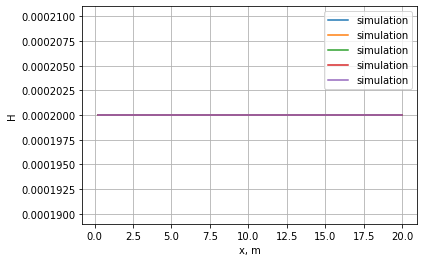

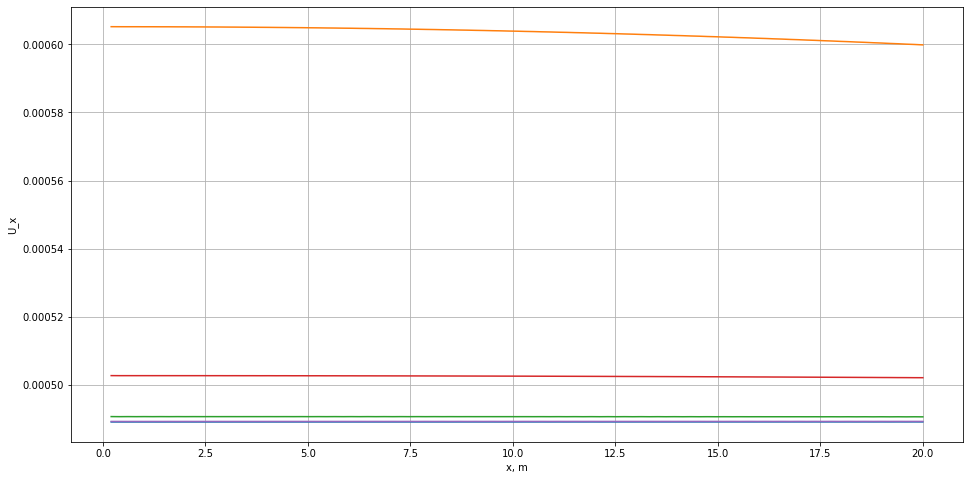

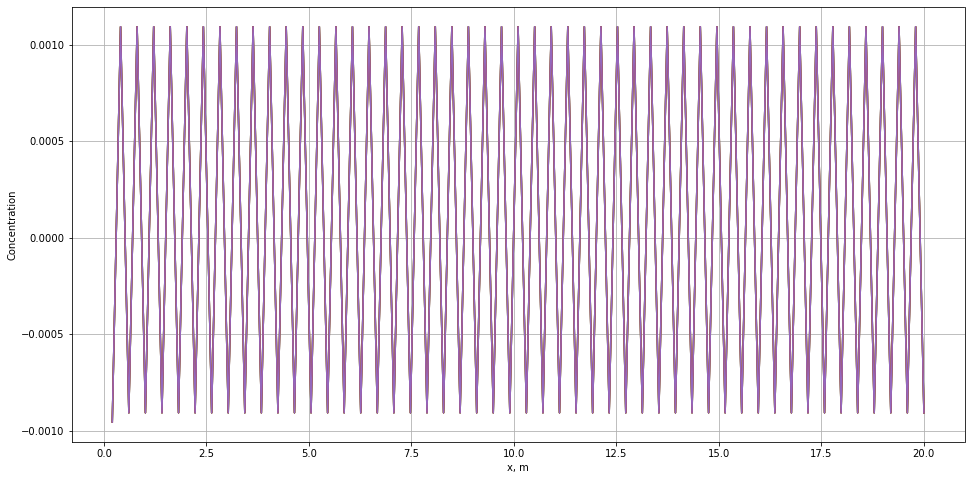

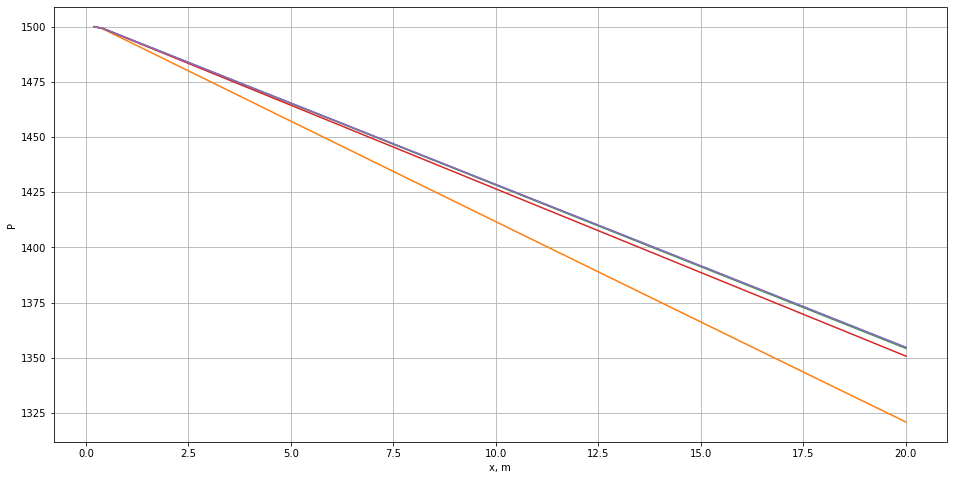

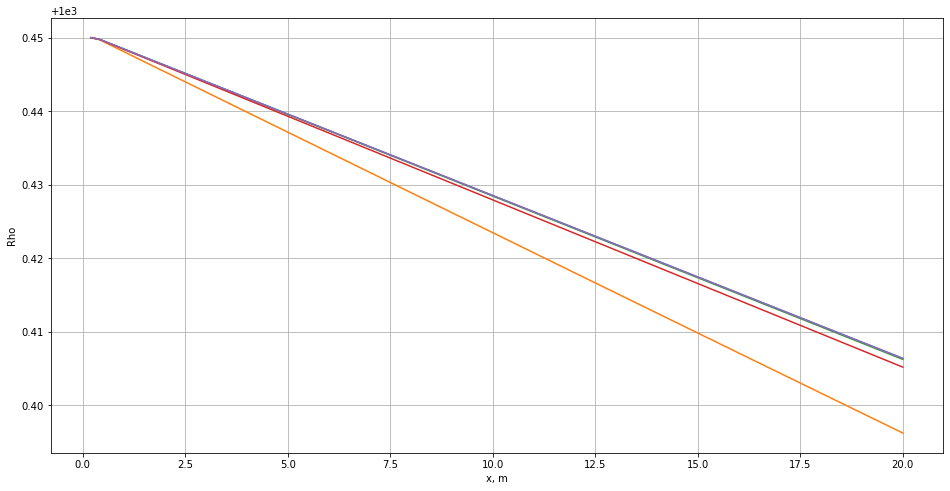

In [3]:
##### --- USER EDITABLE PART --- ####################################

mode = "rysy"
# mode = "pc"

# Dimensionless params
Pe = 100
Da = 5e-4
lam = 0.5e-4

# _l denotes lattice units
D = 1e-9

Csol = 2702.322
Csat = 0.2

x_start = 1
x_end = 100

##### --- END OF USER EDITABLE PART --- #################################


if mode == 'rysy':
  rysy_path = "/home/tadek/Projects/TCLB/rysy_output/output"
  xml_file = glob.glob("/home/tadek/Projects/TCLB/rysy_output/output/*.xml")
  xml = ET.parse(xml_file[0])
  files = glob.glob("/home/tadek/Projects/TCLB/rysy_output/output/*.h5")
elif mode == 'pc':
  pc_path = "/home/tadek/Projects/TCLB/output/"
  xml = ET.parse("/home/tadek/Projects/TCLB/example/flow/2d/fracture.xml")
  files = glob.glob("/home/tadek/Projects/TCLB/output/*.h5")

root = xml.getroot()

C_l = root.findall("Units/Param")[1].get("value")
print("C_l =", C_l)
C_l = float(C_l[:-1])
L = root.find("Geometry").get("nx") 
if L[-1:] == 'm':
  L = float(L[:-1])
else:
  L = float(L)*C_l
print("L =", L, "m")
nu = root.findall("Units/Param")[0].get("value")
print("nu =", nu)
nu = float(nu[:-4])
nu_lbm = float(root.findall("Units/Param")[0].get("gauge"))
print("nu_lbm =", nu_lbm)
C_nu = nu/nu_lbm
C_t = C_l**2 / C_nu

correction = 1

# write_step  = root.find("Solve/HDF5").get("Iterations")
# warmup_time = root.findall("Solve")[0].get("Iterations")
# iterations  = root.findall("Solve")[1].get("Iterations") 
# if write_step[-1:] == 's':
#   write_step = write_step[:-1]
#   write_step = int(float(write_step)/C_t) + correction
# if warmup_time[-1:] == 's':
#   warmup_time = warmup_time[:-1]
#   warmup_time = int(float(warmup_time)/C_t) + correction 
# if iterations[-1:] == 's':
#   iterations = iterations[:-1]
#   iterations = int(float(iterations)/C_t) + warmup_time + correction 
# write_step = int(write_step)
# warmup_time = int(warmup_time)
# iterations = int(iterations) + warmup_time
# print("write_step  =", write_step)
# print("warmup_time =", warmup_time)
# print("iterations  =", iterations)

write_step = int(5*3153600/C_t) + 1
warmup_time = 0
iterations = int(3153600*50/C_t) + 1

print("write_step  =", write_step)
print("warmup_time =", warmup_time)
print("iterations  =", iterations)

q0_l = Pe * D/C_l/C_l*C_t
h0_l = lam*L/C_l
k_l = Da * q0_l / h0_l
lp_l = q0_l / (2*k_l)
tau_l = h0_l *  Csol / (2 * k_l * Csat)

print('q0_l =', q0_l, 'q0 = ', Pe * D) 
print('h0_l =', h0_l, 'h0 = ', lam*L) 
print('k_l =', k_l, 'k = ', Da * Pe * D / lam/L) 
print('lp_l =', lp_l, 'lp = ', lp_l*C_l,'m') 
print('tau_l =', tau_l, 'tau = ', tau_l*C_l,'s') 

x_m = np.linspace(0,L,x_end)

P = list()
Rho = list()
Q_x = list()
C = list()
H = list()

for file in files:
    f = h5py.File(file)  
    C.append(f['C'][0,:,:])
    P.append(f['P'][0,:,:])
    Rho.append(f['Rho'][0,:,:])
    Q_x.append(f['Q'][0,:,:,0])
    H.append(f['H'][0,:,:])

# for u in Q_x:
#     plt.imshow(u)
#     plt.title("Q_x")
#     plt.colorbar()
#     plt.show()

# for rho in Rho:
#     plt.imshow(rho)
#     plt.title("Rho")
#     plt.colorbar()
#     plt.show()

# for p in P:
#     plt.imshow(p)
#     plt.title("P")
#     plt.colorbar()
#     plt.show()

# for h in H:
#     plt.imshow(h)
#     plt.title("H")
#     plt.colorbar()
#     plt.show()

# for c in C:
#     plt.imshow(C[files.__len__()-1])
#     plt.title("C")
#     plt.colorbar()
#     plt.show()

P = np.array(P,dtype=object)
Rho = np.array(Rho, dtype=object)
C = np.array(C, dtype=object)
H = np.array(H, dtype=object)
Q_x = np.array(Q_x, dtype=object)

# plt.figure(figsize=(16,8))
# for t in range(0,iterations,write_step):
#   if t > warmup_time:
#     plt.plot(x_m[x_start:x_end], np.array(h0_l*C_l*(1 + (t-warmup_time)/tau_l*np.exp(-x_m/(lp_l*C_l))))[x_start:x_end], '--',  label='analitic')
plt.plot(x_m[x_start:x_end], H[:,2,x_start:x_end].T, '-',  label='simulation')
plt.grid(which='both')
plt.legend()
plt.xlabel('x, m')
plt.ylabel('H')

plt.figure(figsize=(16,8))
plt.plot(x_m[x_start:x_end], Q_x[:,2,x_start:x_end].T, '-')
plt.grid(which='both')
plt.xlabel('x, m')
plt.ylabel('Q_x')

plt.figure(figsize=(16,8))
plt.plot(x_m[x_start:x_end], C[:,2,x_start:x_end].T, '-')
plt.grid(which='both')
plt.xlabel('x, m')
plt.ylabel('Concentration')

plt.figure(figsize=(16,8))
plt.plot(x_m[x_start:x_end], P[:,2,x_start:x_end].T, '-')
plt.grid(which='both')
plt.xlabel('x, m')
plt.ylabel('P')

plt.figure(figsize=(16,8))
plt.plot(x_m[x_start:x_end], Rho[:,2,x_start:x_end].T, '-')
plt.grid(which='both')
plt.xlabel('x, m')
plt.ylabel('Rho')

In [63]:
##### --- USER EDITABLE PART --- ####################################

# mode = "rysy"
mode = "pc"

# Dimensionless params
Pe = 100
Da = 2e-3
lam = 1e-4

# _l denotes lattice units
D = 1e-9

Csol = 2702.322
Csat = 0.2

x_start = 1
x_end = 101
L = 1

##### --- END OF USER EDITABLE PART --- #################################

C_l = 0.01m
L = 1.02 m
nu = 1e-6m2/s
nu_lbm = 1e-05
write_step  = 15768000000
warmup_time = 0
iterations  = 157680000000
q0_l = 1.0000000000000002e-06 q0 =  1.0000000000000001e-07
u0_l = 9.803921568627452e-05 u0 =  0.000980392156862745
h0_l = 0.0102 h0 =  0.00010200000000000001
k_l = 1.9607843137254906e-07 k =  1.9607843137254906e-06
lp_l = 2.55 lp =  0.0255 m
tau_l = 351436976.0999999 tau =  3514369.760999999 s


Text(0, 0.5, 'Rho')

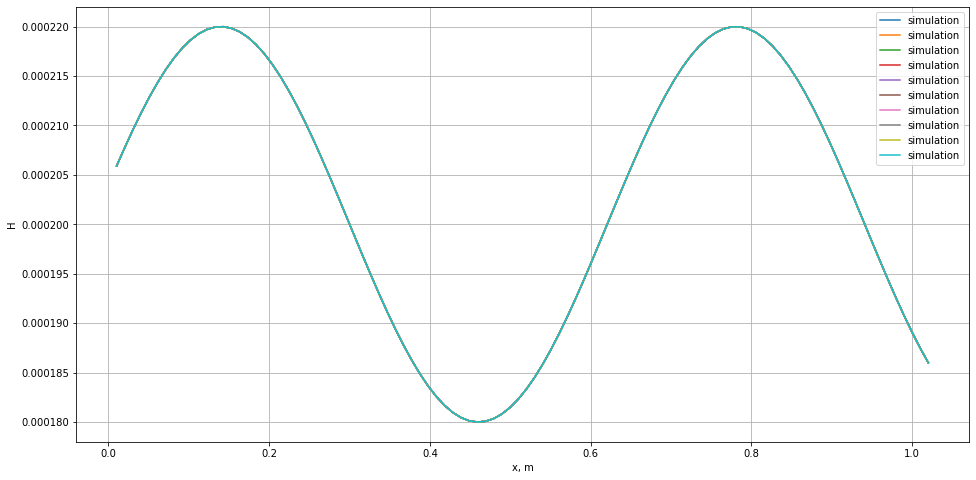

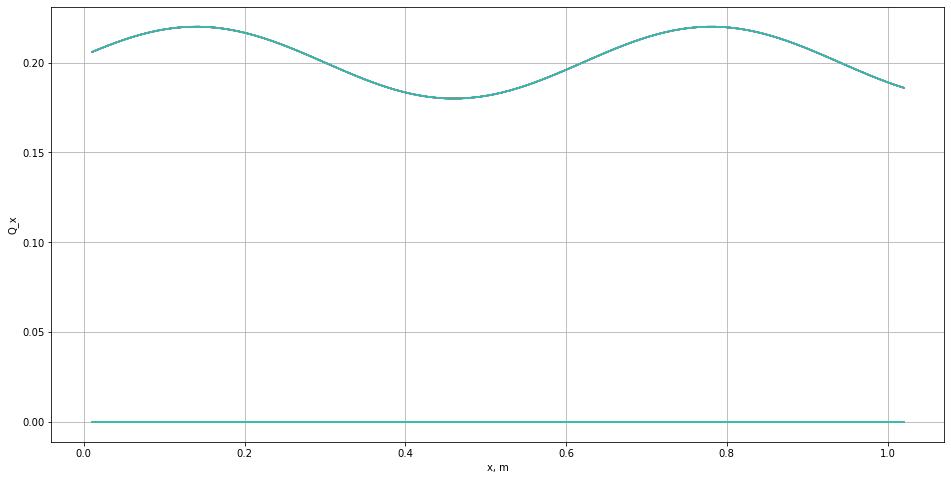

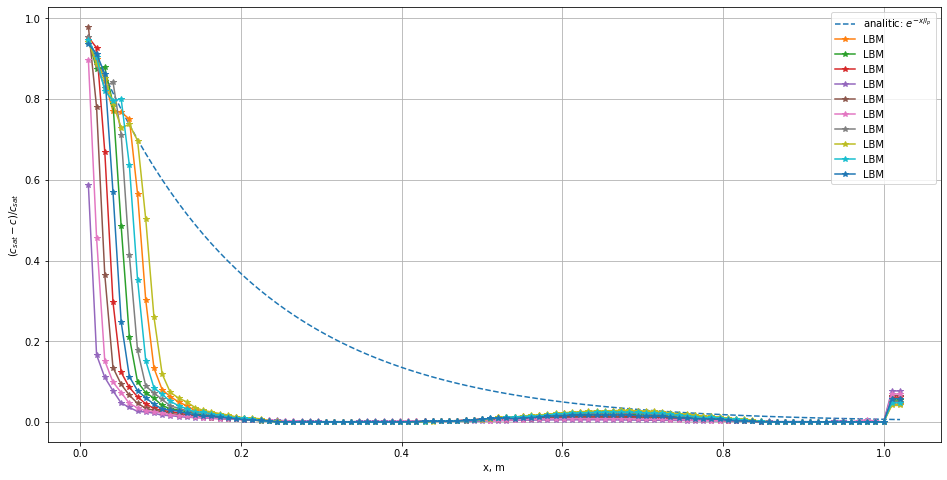

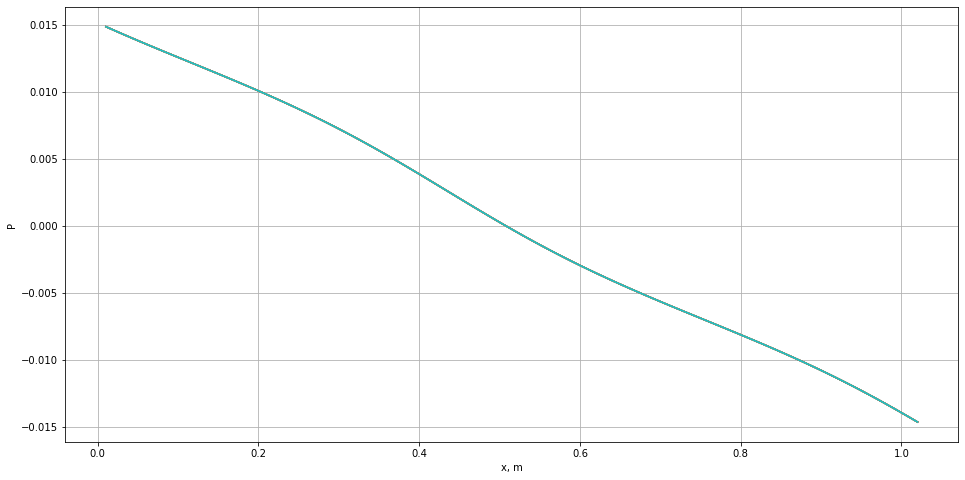

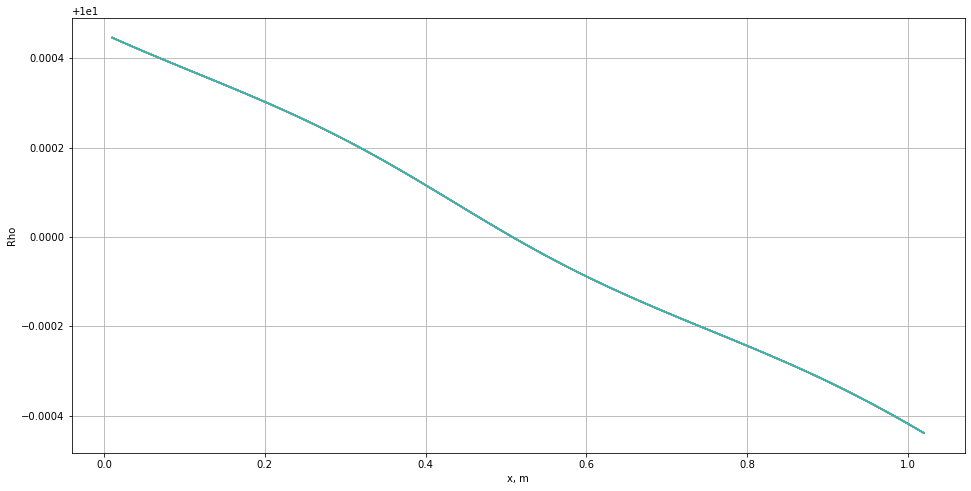

In [96]:
if mode == 'rysy':
  rysy_path = "/home/tadek/Projects/TCLB/rysy_output/output"
  xml_file = glob.glob("/home/tadek/Projects/TCLB/rysy_output/output/*.xml")
  xml = ET.parse(xml_file[0])
  files = glob.glob("/home/tadek/Projects/TCLB/rysy_output/output/*.h5")
elif mode == 'pc':
  pc_path = "/home/tadek/Projects/TCLB/output/"
  xml = ET.parse("/home/tadek/Projects/TCLB/example/flow/2d/fracture.xml")
  files = glob.glob("/home/tadek/Projects/TCLB/output/*.h5")

root = xml.getroot()

C_l = root.findall("Units/Param")[1].get("value")
print("C_l =", C_l)
C_l = float(C_l[:-1])
L = root.find("Geometry").get("nx") 
if L[-1:] == 'm':
  L = float(L[:-1])
else:
  L = float(L)*C_l
print("L =", L, "m")
nu = root.findall("Units/Param")[0].get("value")
print("nu =", nu)
nu = float(nu[:-4])
nu_lbm = float(root.findall("Units/Param")[0].get("gauge"))
print("nu_lbm =", nu_lbm)
C_nu = nu/nu_lbm
C_t = C_l**2 / C_nu

# correction = 1

# write_step  = root.find("Solve/HDF5").get("Iterations")
# warmup_time = root.findall("Solve")[0].get("Iterations")
# iterations  = root.findall("Solve")[1].get("Iterations") 
# if write_step[-1:] == 's':
#   write_step = write_step[:-1]
#   write_step = int(float(write_step)/C_t) + correction
# if warmup_time[-1:] == 's':
#   warmup_time = warmup_time[:-1]
#   warmup_time = int(float(warmup_time)/C_t) + correction 
# if iterations[-1:] == 's':
#   iterations = iterations[:-1]
#   iterations = int(float(iterations)/C_t) + warmup_time + correction 
# write_step = int(write_step)
# warmup_time = int(warmup_time)
# iterations = int(iterations) + warmup_time
# print("write_step  =", write_step)
# print("warmup_time =", warmup_time)
# print("iterations  =", iterations)

write_step = int(5*3153600/C_t) + 1
warmup_time = 0
iterations = int(3153600*50/C_t) + 1

print("write_step  =", write_step)
print("warmup_time =", warmup_time)
print("iterations  =", iterations)

q0_l = Pe * D/C_l/C_l*C_t
h0_l = lam*L/C_l
k_l = Da * q0_l / h0_l
lp_l = q0_l / (2*k_l)
tau_l = h0_l *  Csol / (2 * k_l * Csat)
l_p = lp_l*C_l

print('q0_l =', q0_l, 'q0 = ', Pe * D) 
print('u0_l =', q0_l/h0_l, 'u0 = ', Pe * D/h0_l/C_l) 
print('h0_l =', h0_l, 'h0 = ', lam*L) 
print('k_l =', k_l, 'k = ', Da * Pe * D / lam/L) 
print('lp_l =', lp_l, 'lp = ', lp_l*C_l,'m') 
print('tau_l =', tau_l, 'tau = ', tau_l*C_l,'s') 

x_m = np.linspace(0,L,x_end)

P = list()
Rho = list()
Q_x = list()
C = list()
H = list()

for file in files:
    f = h5py.File(file)  
    C.append(f['C'][0,:,:])
    P.append(f['P'][0,:,:])
    Rho.append(f['Rho'][0,:,:])
    Q_x.append(f['Q'][0,:,:,0])
    H.append(f['H'][0,:,:])

# for u in Q_x:
#     plt.imshow(u)
#     plt.title("Q_x")
#     plt.colorbar()
#     plt.show()

# for rho in Rho:
#     plt.imshow(rho)
#     plt.title("Rho")
#     plt.colorbar()
#     plt.show()

# for p in P:
#     plt.imshow(p)
#     plt.title("P")
#     plt.colorbar()
#     plt.show()

# for h in H:
#     plt.imshow(h)
#     plt.title("H")
#     plt.colorbar()
#     plt.show()

# for c in C:
#     plt.imshow(c)
#     plt.title("C")
#     plt.colorbar()
#     plt.show()

P = np.array(P,dtype=object)
Rho = np.array(Rho, dtype=object)
C = np.array(C, dtype=object)
H = np.array(H, dtype=object)
Q_x = np.array(Q_x, dtype=object)

plt.figure(figsize=(16,8))
# for t in range(0,iterations,write_step):
#   if t > warmup_time:
#     plt.plot(x_m[x_start:x_end], np.array(h0_l*C_l*(1 + (t-warmup_time)/tau_l*np.exp(-x_m/(lp_l*C_l))))[x_start:x_end], '--',  label='analitic')
plt.plot(x_m[x_start:x_end], H[:,1,x_start:x_end].T, '-',  label='simulation')
plt.grid(which='both')
plt.legend()
plt.xlabel('x, m')
plt.ylabel('H')

plt.figure(figsize=(16,8))
plt.plot(x_m[x_start:x_end], Q_x[:,1,x_start:x_end].T, '-')
plt.plot(x_m[x_start:x_end], 1000*H[:,1,x_start:x_end].T, '-',  label='simulation')
plt.grid(which='both')
plt.xlabel('x, m')
plt.ylabel('Q_x')

l_p = 0.2
plt.figure(figsize=(16,8))
plt.plot(x_m[x_start:x_end], np.exp(-x_m/l_p)[x_start:x_end], '--',  label='analitic: $e^{-x/l_p}$')
plt.plot(x_m[x_start:x_end], 4.9/5.*(0.2 - C[:,1,x_start:x_end].T)/0.2, '*-', label="LBM")
plt.grid(which='both')
plt.legend()
plt.xlabel('x, m')
plt.ylabel('$(c_{sat}-c)/c_{sat}$')

plt.figure(figsize=(16,8))
plt.plot(x_m[x_start:x_end], P[:,1,x_start:x_end].T, '-')
plt.grid(which='both')
plt.xlabel('x, m')
plt.ylabel('P')

plt.figure(figsize=(16,8))
plt.plot(x_m[x_start:x_end], Rho[:,1,x_start:x_end].T, '-')
plt.grid(which='both')
plt.xlabel('x, m')
plt.ylabel('Rho')